> ### EEE4423: Deep Learning Lab

# LAB \#13: Deep Convolutional Generative Adversarial Network

<h4><div style="text-align: right"> Due date: JUNE 3, 2022.  </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs by 9 AM in the form of [ID_Name_Lab13.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[2017142136] [이관희]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2022-05-27 01:01:56.380714


## 1. Implementation for DCGAN
> **1. Dataset**
>
>   * CelebA dataset
>   * Resize to (64, 64)
>
> **2. Network architecture**
>
>
>   * **Architecture Guideline**
>
> <img src="https://drive.google.com/uc?export=view&id=14gwes9TCu3Dy-CCu48yqa5gPtTi_6np-" alt="no_image" style="width: 700px;"/><br>
>
>
>
>   * **Generative model G**
>     * Xavier initialization (Glorot & Bengio [2])
>       * It makes sure the weights to keep the propagation in a reasonable range through many layers
>       * $V(W)= {2 \over n_in+n_out}$
>       * Use **nn.init.xavier_uniform_** for the Xavier initialization<br>
>       (The authors suggested a proper initialization for DCGAN training, but the xavier initialization also works well)
>     * Latent vector Z for input (size=100)<br>
>       (You need to make its size as (bs, 100, 1, 1) for upconvolution)
>
>     * They set the strides of upconvolutions to 5 but we will set the strides to 4 in this experiment
>
>     * Use the batch normalization except for the last layer
>
>
> <img src="https://drive.google.com/uc?export=view&id=1vXtAOUCIivvL-HWo1I8TUzZhDAFT8njk" alt="no_image" style="width: 800px;"/><br>
>
>
>   * **Discriminative model D**
>     * Xavier Initialization
>     * Real data or fake data for input (size=64x64)
>     * It's structure is the reverse version of the generative model G where the upconvolutions are replaced to convolutions and the last output size is changed to (bs, 1, 1, 1)
>     * Use the batch normalization except for the last layer
>
>
> **3. Loss function**
>  * **Discriminative model D**
>    * Binary cross entropy loss for the real data
>    * Binary cross entropy loss for the fake data <br>
>
>    $-{1 \over N} \sum^{N}_{i=1} y_i^{real}log(D(z_i))+(1-y_i^{real})log(1-D(z_i)) $ <br>
>    $-{1 \over N} \sum^{N}_{i=1} y_i^{fake}log(D(G(z_i)))+(1-y_i^{fake})log(1-D(G(z_i)))$ <br>
>
>    ($y_i^{real}=1, y_i^{fake}=0$)
>
>
>  * **Generative model G**
>    * Binary cross entropy loss for the real data (It is actually fake)
>
>    $-{1 \over N} \sum^{N}_{i=1} y_i^{real}log(D(G(z_i)))+(1-y_i^{real})log(1-D(G(z_i))) $ <br>
>
>    ($y_i^{real}=1$)
>
>
> **4. Training Strategy**
>    * Same as the GAN training algorithm
>    * The generative model G and the discriminative model D are trained alternatively during training
>    * When the parameters of the model D are being updated, the back-propagation in the model G is blocked

## 2. DCGAN with PyTorch

In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import os.path as osp

%matplotlib inline

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Parameter Setting
* You can adjust the parameters to yourself

In [3]:
print('STEP 0: PARAMETER SETTING')

# Data root directory
data_root = '../dataset/lab13/celebA/' 

# Batch size during training
bs = 128 

# Size of image size
img_size = 64

# Channels of generator feature
gfc = 64

# Channels of discriminator feature
dfc = 64

# Size of latent vector z
z_size = 100 

# Number of training epochs
num_epochs = 5

# Learning rate for optimizing
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Real or Fake label
real_label = 1
fake_label = 0

STEP 0: PARAMETER SETTING


In [4]:
print('STEP 1: LOADING DATASET')

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = dset.ImageFolder(root=data_root,
                           transform=transform)

STEP 1: LOADING DATASET


In [5]:
print('STEP 2: MAKING DATASET ITERABLE')

data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=bs, 
                                           shuffle=True,
                                           drop_last=True)

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

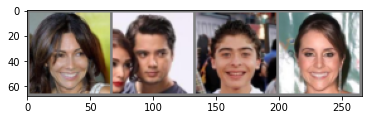

In [7]:
data_loader_sample = torch.utils.data.DataLoader(dataset=dataset, 
                                                 batch_size=4, 
                                                 shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(data_loader_sample))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

### Utils 
* Use the below code for the convolutions or the upconvolutions

In [8]:
def conv2d(params_list, batch_norm = True):
    channel_in, channel_out, kernel_size, stride, padding, activation = params_list
    layers = []
    if batch_norm:
        layers += [nn.Conv2d(channel_in, channel_out, kernel_size, stride, padding, bias=False),
                   nn.BatchNorm2d(channel_out)]
        nn.init.xavier_uniform_(layers[0].weight)
    else:
        layers += [nn.Conv2d(channel_in, channel_out, kernel_size, stride, padding, bias=False)]
        nn.init.xavier_uniform_(layers[0].weight)
        
    if activation == 'ReLU':
        layers += [nn.ReLU(inplace=True)]
    if activation == 'LeakyReLU':
        layers += [nn.LeakyReLU(0.2, inplace=True)]
    if activation == 'Tanh':
        layers += [nn.Tanh()]
    if activation == 'Sigmoid':
        layers += [nn.Sigmoid()]
        
    return nn.Sequential(*layers)
        
    
def upconv2d(params_list, batch_norm = True):
    channel_in, channel_out, kernel_size, stride, padding, activation = params_list
    layers = []
    if batch_norm:
        layers += [nn.ConvTranspose2d(channel_in, channel_out, kernel_size, stride, padding, bias=False),
                   nn.BatchNorm2d(channel_out)]
        nn.init.xavier_uniform_(layers[0].weight)
    else:
        layers += [nn.ConvTranspose2d(channel_in, channel_out, kernel_size, stride, padding, bias=False)]
        nn.init.xavier_uniform_(layers[0].weight)
        
    if activation == 'ReLU':
        layers += [nn.ReLU(inplace=True)]
    if activation == 'LeakyReLU':
        layers += [nn.LeakyReLU(0.2, inplace=True)]
    if activation == 'Tanh':
        layers += [nn.Tanh()]
    if activation == 'Sigmoid':
        layers += [nn.Sigmoid()]
        
    return nn.Sequential(*layers)

### 2.1 Write the code (Generator) [4 points]
* You need to set the hyperparameters for implementing the upconvolutions (params_list)
* There are 'ReLU', 'LeakyReLU', 'Tanh', and 'Sigmoid' for the activation functions
* If you do not want to use the activation function, just put '' in the position of the activation function
* Other parameters, such as paddings, can be determined by calculating the formulation of convolutional process<br>
  (See in https://pytorch.org/docs/stable/nn.html)
* You have to use the functions **conv2d()** or **upconv2d()** which are defined from above

In [9]:
print('STEP 3-1: CREATE MODEL CLASS (Generator)')


# [input channels, output channels, kernel_size, strides, paddings, activation fuctions]
#cfg_g = [[], [], [], [], []]
#
cfg_g = [
    [100,512,4,1,0,'ReLU'], 
    [512,256,4,2,1,'ReLU'], 
    [256,128,4,2,1,'ReLU'], 
    [128,64,4,2,1,'ReLU'], 
    [64,3,4,2,1,'Tanh']
]


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.up1 = upconv2d([100,512,4,1,0,'ReLU'])
        self.up2 = upconv2d([512,256,4,2,1,'ReLU'])
        self.up3 = upconv2d([256,128,4,2,1,'ReLU'])
        self.up4 = upconv2d([128,64,4,2,1,'ReLU'])
        self.up5 = upconv2d([64,3,4,2,1,'Tanh'], False)
        #############
        # CODE HERE #
        #############
        
    def forward(self, x):
        output = self.up1(x)
        output = self.up2(output)
        output = self.up3(output)
        output = self.up4(output)
        output = self.up5(output)
        #############
        # CODE HERE #
        #############
        return output
    
# model_G = Generator()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model_G.to(device)
# print(model_G)

STEP 3-1: CREATE MODEL CLASS (Generator)


### 2.2 Write the code (Discriminator) [4 points]
* You need to set the hyperparameters for implementing the convolutions (params_list)
* There are 'ReLU', 'LeakyReLU', 'Tanh', and 'Sigmoid' for the activation functions
* If you do not want to use the activation function, just put '' in the position of the activation function
* Other parameters, such as paddings, can be determined by calculating the formulation of convolutional process<br>
  (See in https://pytorch.org/docs/stable/nn.html)
* You have to use the functions **conv2d()** or **upconv2d()** which are defined from above

In [10]:
print('STEP 3-2: CREATE MODEL CLASS (Discriminator)')


# [input channels, output channels, kernel_size, strides, paddings, activation fuctions]
cfg_d = [[3,64,4,2,1,'LeakyReLU'],
         [64,128,4,2,1,'LeakyReLU'],
         [128,256,4,2,1,'LeakyReLU'],
         [256,512,4,2,1,'LeakyReLU'],
         [512,1,4,1,0,'Sigmoid']
        ]


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = conv2d([3,64,4,2,1,'LeakyReLU'])
        self.conv2 = conv2d([64,128,4,2,1,'LeakyReLU'])        
        self.conv3 = conv2d([128,256,4,2,1,'LeakyReLU'])
        self.conv4 = conv2d([256,512,4,2,1,'LeakyReLU'])
        self.conv5 = conv2d([512,1,4,1,0,'Sigmoid'],False)
            
        #############
        # CODE HERE #
        #############
        
    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.conv4(output)
        output = self.conv5(output)
        
        return output

# model_D = Discriminator()
# print(model_D)


STEP 3-2: CREATE MODEL CLASS (Discriminator)


In [11]:
print('STEP 4: INSTANTIATE MODEL CLASS')


model_G = Generator()
model_D = Discriminator()


#######################
#  USE GPU FOR MODEL  #
#######################


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_G.to(device)
print(model_G)
model_D.to(device)

STEP 4: INSTANTIATE MODEL CLASS
Generator(
  (up1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (up2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (up3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (up4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (up5): Se

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Le

In [12]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.BCELoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

optimizer_G = torch.optim.Adam(model_G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(model_D.parameters(), lr=lr, betas=(beta1, 0.999))

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### 2.3 Train the DCGAN [2 points]
* After the training is finished, check out the generated samples
* If the samples are generated well, then you will get the full score

STEP 7: TRAIN THE MODEL
[0/5][400/1582]	Loss_D: 0.4515	Loss_G: 3.1222	
[0/5][800/1582]	Loss_D: 0.5333	Loss_G: 3.2841	
[0/5][1200/1582]	Loss_D: 0.9655	Loss_G: 7.4849	
[1/5][400/1582]	Loss_D: 0.6977	Loss_G: 5.4395	
[1/5][800/1582]	Loss_D: 0.4062	Loss_G: 2.9563	
[1/5][1200/1582]	Loss_D: 0.6207	Loss_G: 1.8656	
[2/5][400/1582]	Loss_D: 0.3103	Loss_G: 2.7621	
[2/5][800/1582]	Loss_D: 0.3534	Loss_G: 3.5479	
[2/5][1200/1582]	Loss_D: 0.8063	Loss_G: 5.4052	
[3/5][400/1582]	Loss_D: 0.5350	Loss_G: 2.5011	
[3/5][800/1582]	Loss_D: 0.7143	Loss_G: 3.0056	
[3/5][1200/1582]	Loss_D: 0.4858	Loss_G: 4.2164	
[4/5][400/1582]	Loss_D: 1.5523	Loss_G: 5.7464	
[4/5][800/1582]	Loss_D: 0.4514	Loss_G: 3.9917	
[4/5][1200/1582]	Loss_D: 0.3493	Loss_G: 2.3327	


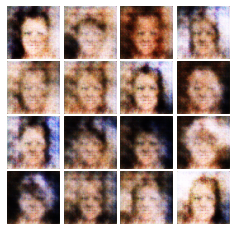

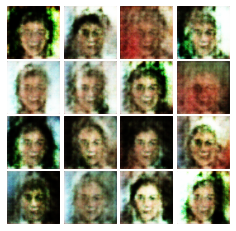

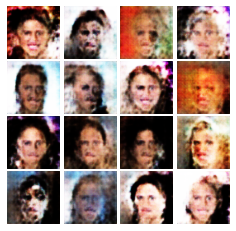

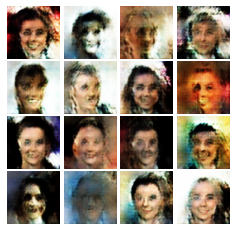

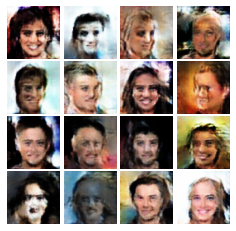

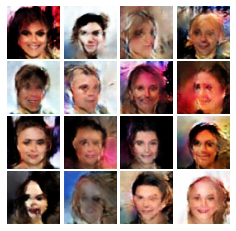

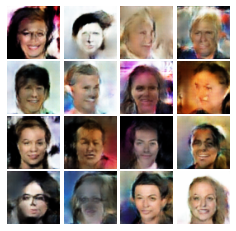

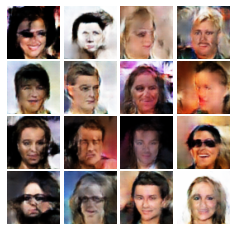

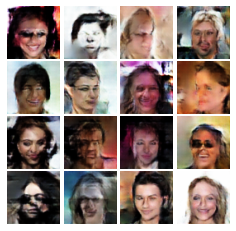

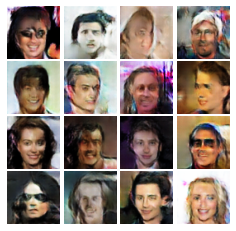

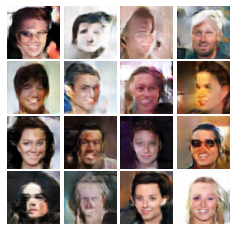

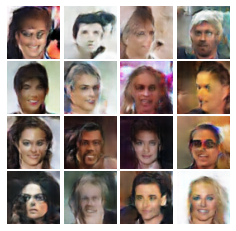

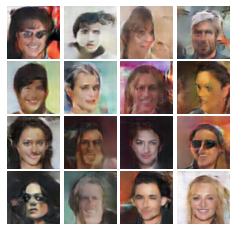

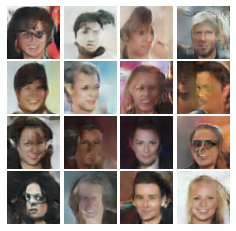

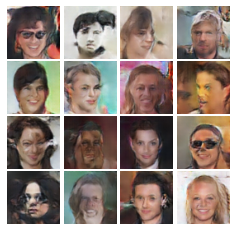

In [13]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(64, 64, 3), cmap='Greys_r')
    return fig

print('STEP 7: TRAIN THE MODEL')

label_real = torch.full((bs,), real_label, device=device, dtype=torch.float)
label_fake = torch.full((bs,), fake_label, device=device, dtype=torch.float)

#  The input noise for inference
fixed_noise = torch.randn(bs, z_size, 1, 1, device=device, dtype=torch.float) # bs = 128  z_size = 100


for epoch in range(num_epochs):
    
    model_G.train()
    model_D.train()
    
    for i, data in enumerate(data_loader):
        
        data = data[0].to(device)
        
        ### Update discriminator model
        
        # Clear gradients w.r.t. parameters
        model_D.zero_grad()
        
        # Forward pass to get results of discriminator for real data
        output_D_real = model_D(data).view(-1)
        
        # Calculate Loss
        err_D_real = criterion(output_D_real, label_real)
        
        # Generating noise inputs for generating fake samples
        noise = torch.randn(bs, z_size, 1, 1, device=device)
        
        # Forward pass to get generated samples
        output_G = model_G(noise)
        
        # Forward pass to get results of discriminator for fake data
        output_D_fake = model_D(output_G.detach()).view(-1)
        
        # Calculate Loss
        err_D_fake = criterion(output_D_fake, label_fake)
        
        # Combine the losses for real data and fake data
        err_D = err_D_real + err_D_fake
        
        # Getting gradients w.r.t. parameters
        err_D.backward()
        
        # Updating parameters
        optimizer_D.step()
        
        
        ### Update generator model
        
        # Clear gradients w.r.t. parameters
        model_G.zero_grad()
        
        # Forward pass to get results of discriminator for fake data
        output_G_real = model_D(output_G).view(-1)
        
        # Calculate Loss
        err_G = criterion(output_G_real, label_real)
        
        # Getting gradients w.r.t. parameters
        err_G.backward()
        
        # Updating parameters
        optimizer_G.step()
        
        # Output training stats
        if i % 400 == 0 and i != 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(data_loader),
                     err_D.item(), err_G.item()))

            model_G.eval()
            model_D.eval()
            with torch.no_grad():
                output = model_G(fixed_noise).detach().cpu().numpy()
                output = np.transpose((output+1)/2, (0, 2, 3, 1))
                fig = plot(output[:16])
                
            model_G.train()
            model_D.train()
         

### *References*
[1] Radford et al., "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial network", *ICLR*, 2016. <br>
[2] Glorot & Bengio, "Understanding the difficulty of training deep feedforward neural networks", *AISTATS* 2010 <br>

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

GAN 논문에서는 Generator model을 두 개의 model인 discriminator과 generator을 사용해서 구현하였다. 
이는 minmax game player과 같으며 서로 서로 다른 방향으로 학습되기 때문에 적대적이라는 의미인 Adversarial 용어가 붙었다. 
D의 경우에는 G의 거짓된 이미지를 잘 판별하도록 설계가 되었고 반면에 G의 경우에는 D가 판단을 할 때 자신이 만든 이미지가 진짜 이미지와
구분하지 못하도록 설계하였다. GAN의 경우에는 backpropagation으로만 학습할 수 있기 때문에 기존의 generator model보다 구현상 더 편리하다.
또한 G와 D의 성능 차이는 많이 나면 학습이 안될 수 있다고 논문에서 밝힌다. DCGAN의 경우에는 GAN이 실제 이미지의 feature을 가지고 새로운 이미지를 만들어낸다는 것을 밝힌 논문이다. 즉 data를 학습시킬 때 단순히 pixel의 값을 복사하는 것이 아니라 이미지의 feature을 가지고 그에 따른 현실에 없는 새로운 데이터를 만든다는 것이다.

예상했던 점 : GAN을 응용해서 발전시킨 DCGAN의 경우에 현실 data와 유사한 그림을 noise vector에서 생성해 낼 수 있다.

예상과 달랐던 점 및 개선할 점 : 코드 상에서 GAN에서 D는 항상 G가 만들어낸 데이터를 거짓으로 학습하도록 설계가 되어져있었다. G가 많은 iteration을 돌아도 D는 G가 만들어 내는 것을 거짓으로 뱉어내기 때문에 G가 만드는 것은 언제든지 거짓이라는 점이 의문점이었다. 왜냐하면 G는 D가 판단하길 진실로 학습된다고 하지만 D의 입장에서는 현실의 데이터와 같은 데이터도 거짓이라고 판단해서 학습될 수 있기 때문이다. 그러면 다음 step에서 G는 D을 속이기 위해서 현실과 다른 데이터를 만들어 낼 수도 있겠다는 생각을 하게 되었다. 이런 이유 때문에 학습이 안될 수도 있을 것 같다는 생각이 들었다. 또한 학습에 걸리는 시간이 너무 오래 걸렸다.
위의 문제를 해결하기 위해서 생각한 방법으로는 G에 대한 loss 값이 일정 이하로 내려갔을 때는 D가 인지하는 G가 만들어내는 이미지를 진실로 파악하도록 설계하는 방법이 있을 것으로 생각된다. 이렇게 되면 G가 만들어내는 이미지가 더 신뢰성이 있지 않을까 생각한다.

결론 : 결론적으로 학습을 돌리고 그에 대한 결과를 살펴보았다. hyperparameter에 굉장히 민감한 GAN 모델에서 조금의 parameter을 구체화 시킨 것이 DCGAN으로 학습이 더 잘되게 설계했다고 볼 수 있다.

의문점 : GAN이 학습시켜도 좋은 이미지를 뱉어내기 어렵고 학습 시간이 매우 오래 걸려 다시 학습 시키기가 쉽지 않았다. 그래서 이 같은 속도를 빠르게 학습하는 방법이나 발전된 GAN중에서 hyperparameter에 민감하지 않는 다른 model이 있는지 궁금하다.